In [1]:
%load_ext autoreload
%autoreload 2


In [10]:
from functools import reduce
import scipy
from copy import deepcopy
from scipy.linalg import logm
import numpy as np
import dill
import os
from os.path import isfile, join
import matplotlib.pyplot as plt

In [21]:
mypath = 'controls_106'
filename = os.path.join(mypath,'pickled_controls106.pkl')
pca = dill.load(open(filename, 'rb'))

# Look at the number of controls in the optimized weighting. In particular, they've been assigned WITHOUT cardinality constraints. 

In [35]:
def hist_and_support(weights, num=10):
    plt.hist(weights)
    plt.xlabel("Probability")
    plt.ylabel("Number of controls with probability")
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx

SUPPORT:0.05292574429658141
NUM CONTROLS: 10


array([ 93, 251, 312,  48, 174, 203, 212, 166, 147, 134])

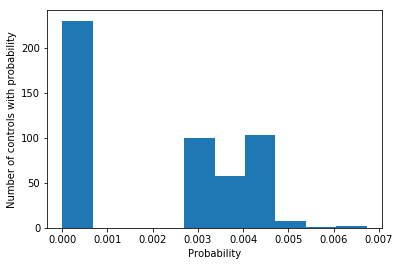

In [36]:
hist_and_support(pca.weights_0)

SUPPORT:0.10573942236230383
NUM CONTROLS: 10


array([432,  38, 344, 453, 433, 203, 134, 398, 393, 318])

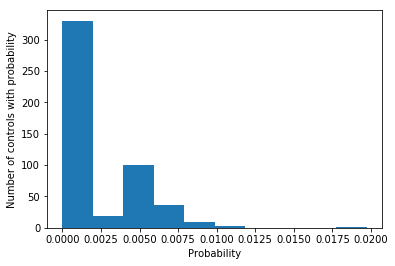

In [37]:
hist_and_support(pca.weights)

# We can try preparing sparse solutions, but I haven't done this. It takes a while. The above solutions are very non-sparse. This will change the weights on the PCA object, so if you do run this, and you want the old weights, you'll need to reload the pickle above.

In [20]:
from pauli_channel_approximation import PCA
constraint_for_zeroth = 1E-3 
constraint_for_first = 1E-3
PCA.assign_weights(pca, l1=constraint_for_first, l2=constraint_for_zeroth)

Done with convex problem 1 out of 500
Done with convex problem 2 out of 500
Done with convex problem 3 out of 500
Done with convex problem 4 out of 500
Done with convex problem 5 out of 500
Done with convex problem 6 out of 500
Done with convex problem 7 out of 500
Done with convex problem 8 out of 500


KeyboardInterrupt: 

# Compute Derivatives (0 and 1) this takes a long time. 

In [38]:
from convex import all_derivs
derivs = all_derivs(pca.controlset, pca.target_operator, pca.control_hamiltonians, pca.ambient_hamiltonian, pca.dt, 1)

# Norm of Average Hamiltonian (Both are relatively good)

In [39]:
order = 0
# Zeroth order optimized weights
scipy.linalg.norm(np.matrix([d.flatten() for d in derivs[order]]).T.dot(pca.weights_0))

9.799600050962165e-13

In [40]:
order = 0
# First order optimized weights
scipy.linalg.norm(np.matrix([d.flatten() for d in derivs[order]]).T.dot(pca.weights))

4.353241044386789e-16

# Norm of the First Derivative of the Average Hamiltonian (We get an improvement of around an order of magnitude)

In [41]:
order = 1
# Zeroth order optimized
scipy.linalg.norm(np.matrix([d.flatten() for d in derivs[order]]).T.dot(pca.weights_0))

4.515072349308713

In [42]:
order = 1
# First order optimized
scipy.linalg.norm(np.matrix([d.flatten() for d in derivs[order]]).T.dot(pca.weights))

0.33898776606987385

# If you'd like to look at the controls, you can inspect pca.controlset. They're organized as IX, IY, XI, YI. For instance, we can look at some of the controls on the IX term, as see that some flip the gate sharply at certain times. The random looking ones are on a very different scale.

In [74]:
first_few_controls = [c[:, 0] for c in pca.controlset][:10]

def tophats(control):
    times = list(range(len(control)))
    points = [control[0]]
    xpoints = [times[0]]
    for i, point in enumerate(control[1:-2]):
        points.append(point)
        points.append(point)
        xpoints.append(times[i+1])
        xpoints.append(times[i+1])
    points.append(control[-1])
    xpoints.append(times[-1])
    plt.step(xpoints, points)

In [76]:
first_few_controls[1]

array([ 7.99762774e+00,  7.83255939e-03, -6.87713146e-05,  7.33565933e-03,
        7.67509572e-03, -1.74774581e-04,  1.65500442e-03, -5.54165919e-03,
       -3.01116813e-03,  3.50433560e-03, -3.72991386e-03, -7.53566811e-03,
        6.22785413e-03,  4.47997771e-03, -7.79485644e-04, -9.13755050e-04,
       -3.12947960e-03,  6.22763760e-04, -4.71342079e-03, -3.39150840e-03,
        8.33848806e-03,  5.34682947e-03,  9.46733057e-03, -2.62050395e-03,
       -5.86628933e-03,  1.03893520e-02, -7.85865034e-03,  1.04074957e-02,
       -7.22569092e-03, -6.39564151e-03, -8.77212840e-03, -6.38950943e-03,
       -1.06644132e-02, -5.11933716e-03, -4.10647239e-03,  4.13160410e-03,
        7.49938055e-03, -3.00780326e-03, -7.08272650e-03, -7.99507123e+00])

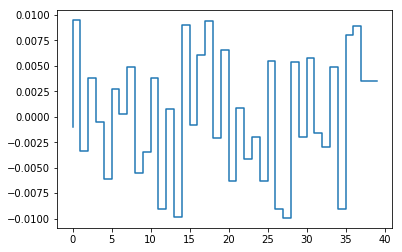

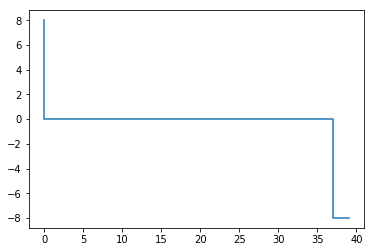

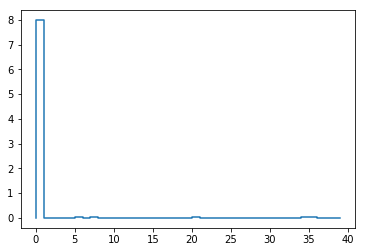

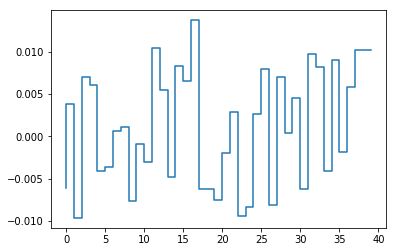

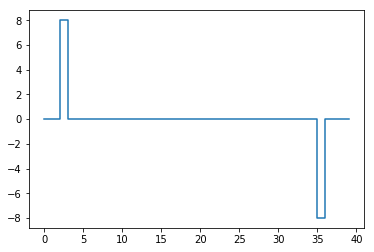

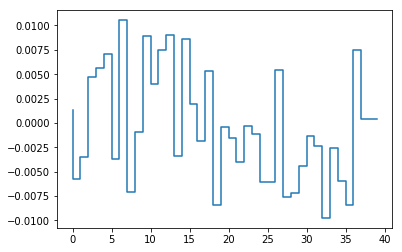

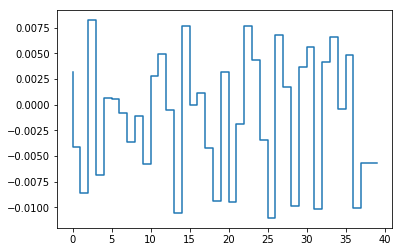

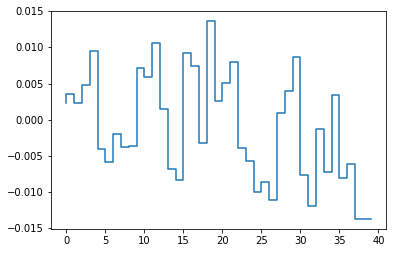

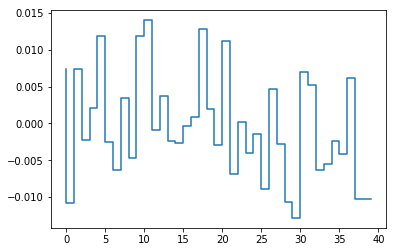

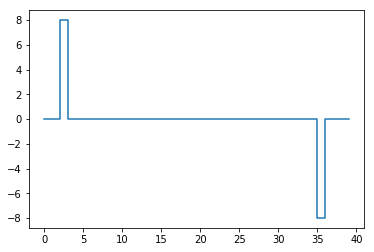

In [75]:
for c in first_few_controls:
    tophats(c)
    plt.show()

In [101]:
mypath = 'controls_106'
filename = os.path.join(mypath,'pickled_controls106.pkl')
pca = dill.load(open(filename, 'rb'))

def bangbang(index, x, d1, d2, d3, d4):
    if x:
        xory = 0
    else:
        xory = 1
    dt = pca.dt
    num_steps = pca.controlset[0].shape[0]
    control_hamiltonians = pca.control_hamiltonians
    controls = np.zeros((num_steps, int(len(pca.control_hamiltonians))))
    controls[index, xory] = (1 / dt * np.pi / 2) * d1
    controls[-(index+1), xory] = 1 / dt * np.pi / 2 * d2
    controls[index, 2+xory] = 1 / dt * np.pi / 2 * d3
    controls[-(index+1), 2+xory] = 1 / dt * np.pi / 2 * d4
    return controls

controls = []
import itertools
for directions in list(itertools.product([-1, 1], repeat=4)):
    for x in (True, False):
        for i in range(int(pca.controlset[0].shape[0]/2)):
            controls.append(bangbang(i, x, *directions))
pca.controlset = controls
pca.num_controls = len(pca.controlset)

In [102]:
from convex import all_derivs
derivs = all_derivs(pca.controlset, pca.target_operator, pca.control_hamiltonians, pca.ambient_hamiltonian, pca.dt, 1)

In [106]:
from pauli_channel_approximation import PCA

/home/anthony/repos/decorrelating_errors/code/pauli_channel_approximation.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/anthony/.pyenv/versions/3.6.3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/anthon

In [116]:
PCA.assign_weights(pca, 1E-1, 1E-1)

Starting optimal weights no constraints 1st order
Starting optimal weights no constraints
Tried assigning weights.


SUPPORT:0.031054692047283755
NUM CONTROLS: 10


array([401, 361, 240, 260, 220, 200, 400, 380, 360, 420])

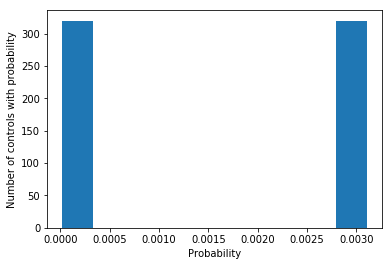

In [119]:
hist_and_support(pca.weights_0)

SUPPORT:0.9979040429340997
NUM CONTROLS: 10


array([139, 499, 179, 459, 339, 299, 379, 259, 219, 419])

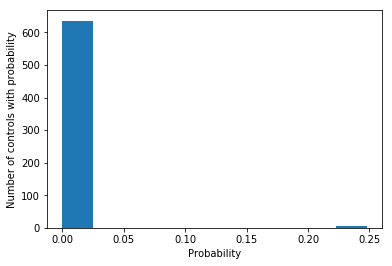

In [120]:
hist_and_support(pca.weights)

In [121]:
order = 0
# Zeroth order optimized weights
scipy.linalg.norm(np.matrix([d.flatten() for d in derivs[order]]).T.dot(pca.weights_0))

2.9055796725364706e-11

In [122]:
order = 0
# Zeroth order optimized weights
scipy.linalg.norm(np.matrix([d.flatten() for d in derivs[order]]).T.dot(pca.weights))

1.454152069275039e-15

In [123]:
order = 1
# Zeroth order optimized weights
scipy.linalg.norm(np.matrix([d.flatten() for d in derivs[order]]).T.dot(pca.weights_0))

0.009831444822610315

In [124]:
order = 1
# Zeroth order optimized weights
scipy.linalg.norm(np.matrix([d.flatten() for d in derivs[order]]).T.dot(pca.weights))

0.019616914024841503